In [78]:
import numpy as np
import matplotlib.pyplot as plt
from qreservoirpy import QReservoir, Layers, utilities

from qiskit.extensions import HamiltonianGate

## Initialization

In [79]:
n_qubits = 8
SHOTS = 10000

timeseries = [0, 1, 2, 1, 2] * 10
encoder = {
    0: '00',
    1: '01',
    2: '10',
    3: '11'
} 

placement = {
    0: [0, 1],
    1: [1, 2],
    2: [2, 3],
}

H = utilities.random_ising_H(num_qubits=n_qubits, num_terms=40)
T = 0.1 #s
UT = HamiltonianGate(H, T, label="UT")

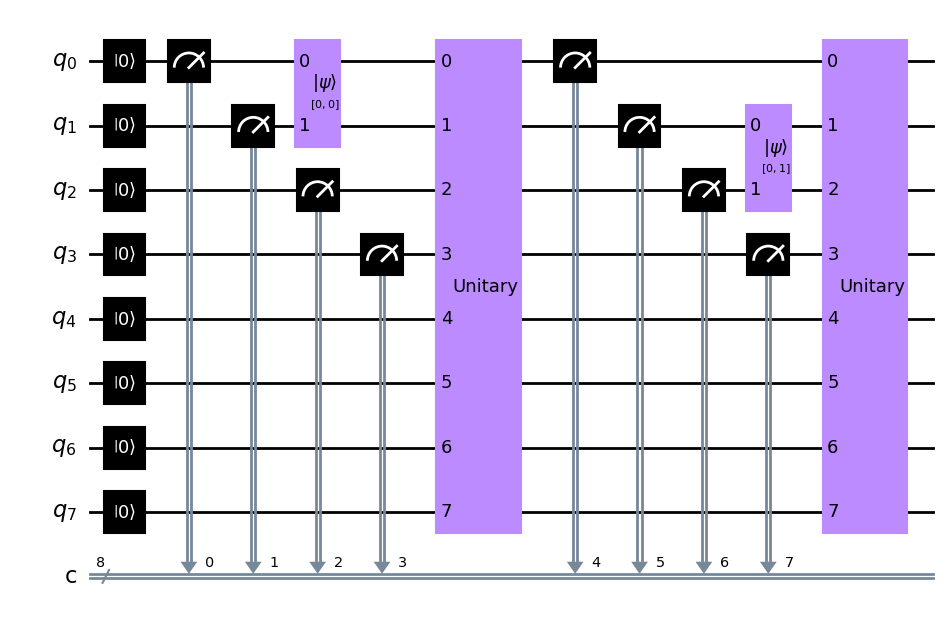

In [80]:

def build_method(circuit, timestep, encoding, reservoir, pos):
    circuit.measure(range(4))
    circuit.initialize(encoding[timestep], pos[timestep])
    # circuit.initialize(encoding[timestep], [2, 3])
    circuit.unitary(reservoir, circuit.qubits)

qres = QReservoir(qubits=n_qubits, layers=[
    Layers.Reset(),
    Layers.Timeseries(build_method=build_method, 
                      encoding = encoder,
                      reservoir = UT,
                      pos = placement)
])
qres.circuit.draw('mpl')

## Running

In [81]:
states = qres.run(
    timeseries=timeseries, 
    shots=SHOTS
)


Simulating: 100%|██████████| 1/1 [05:27<00:00, 327.03s/it]


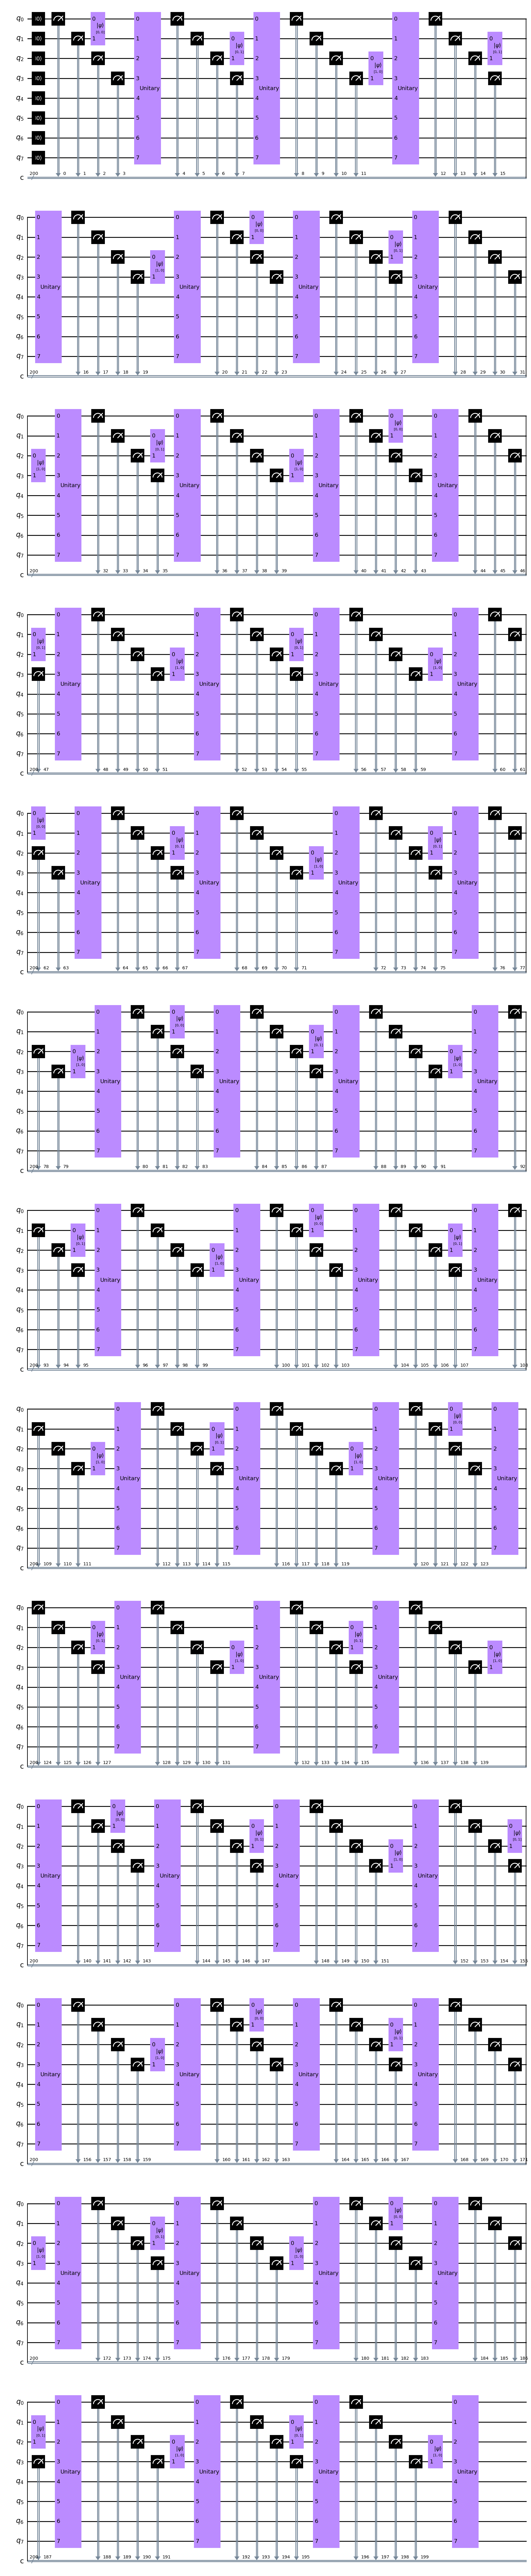

In [82]:
qres.circuit.draw('mpl')

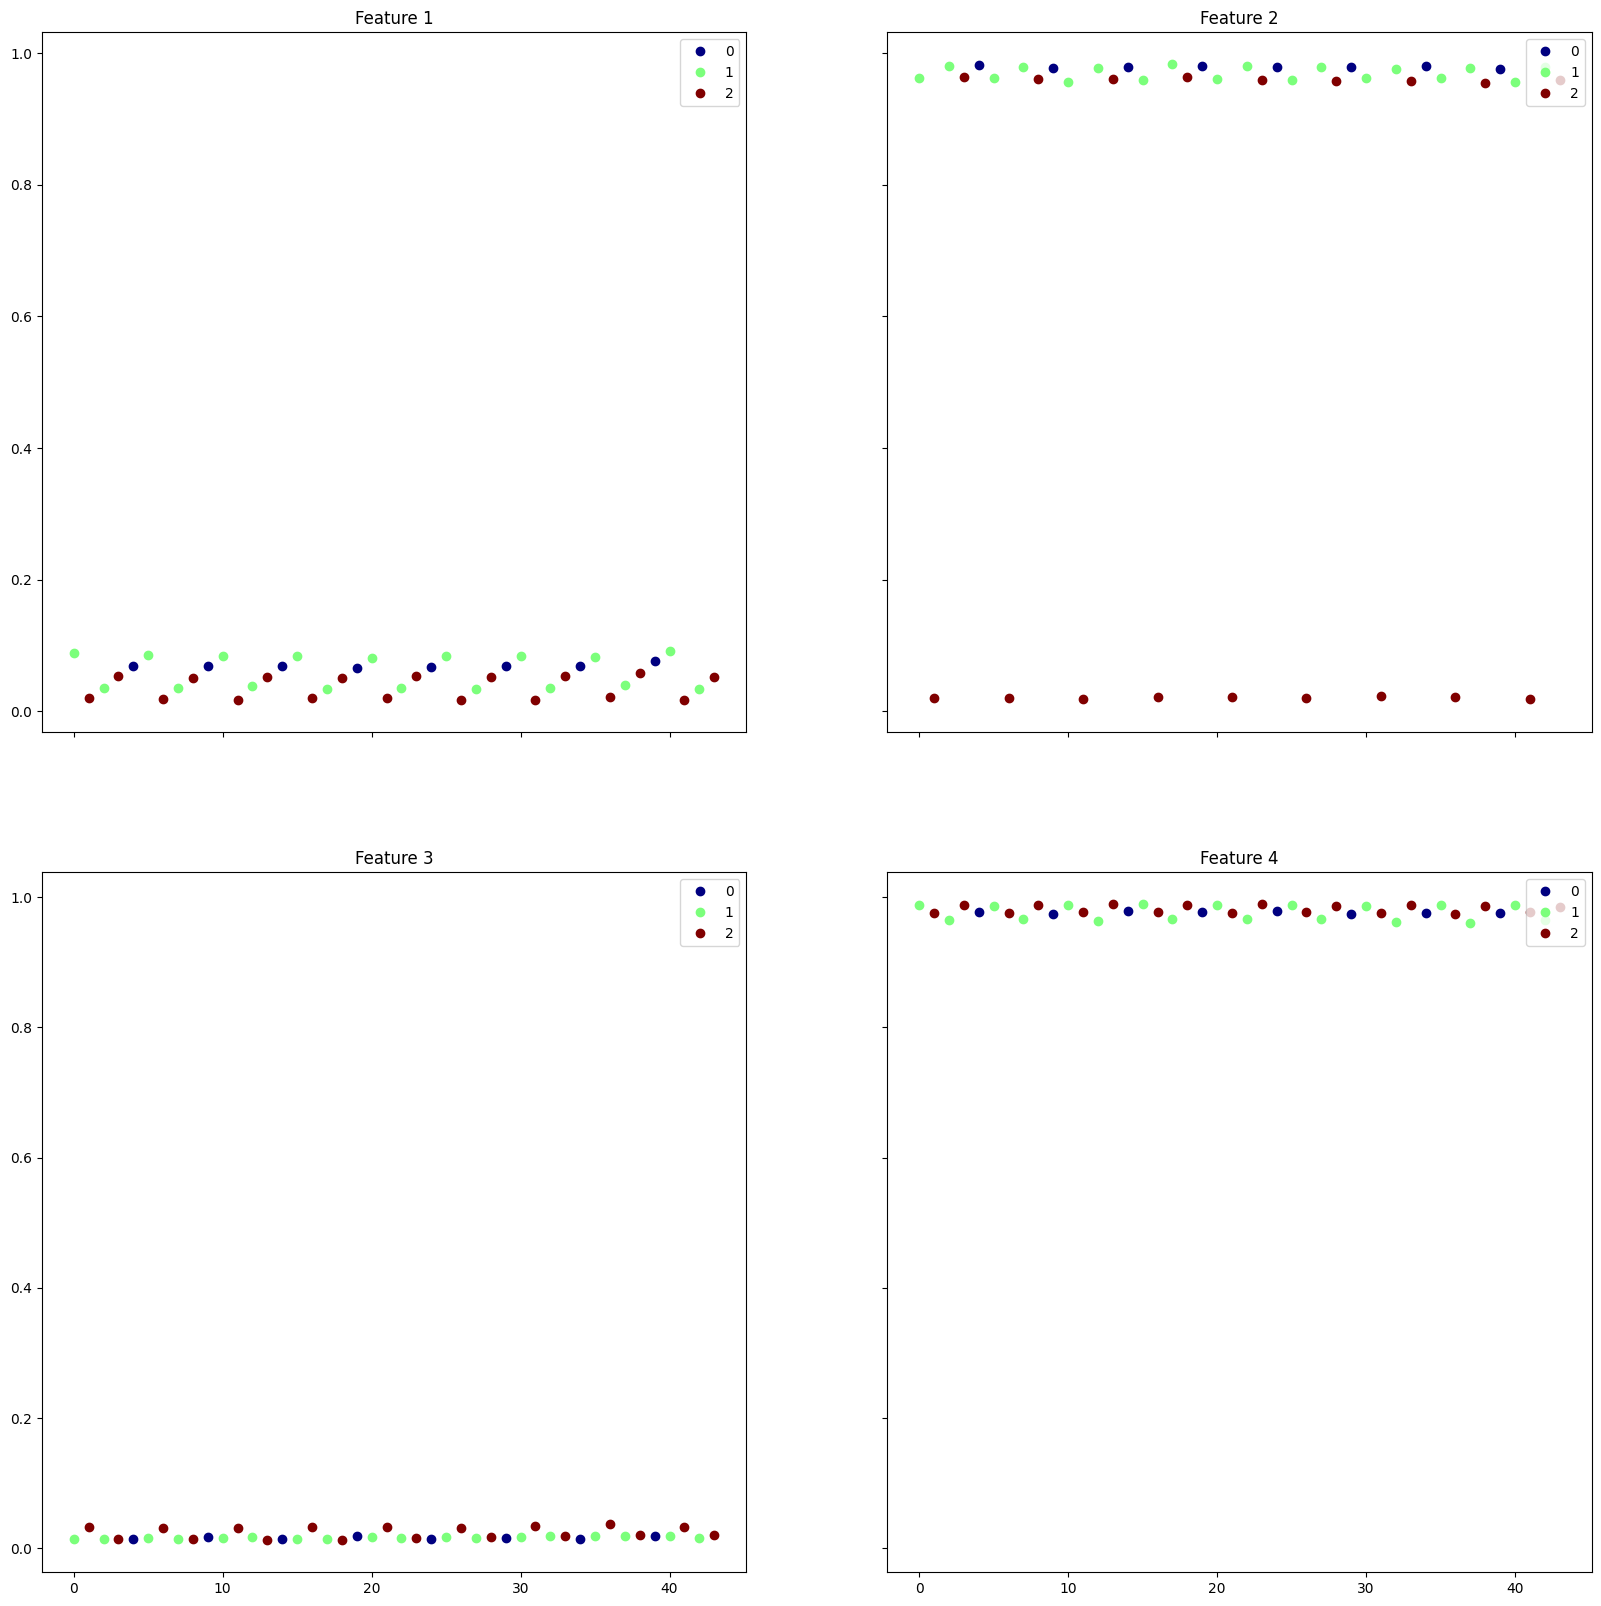

In [83]:
WARMUP = 0.1 # 10%
warmup_idx = int(len(states) * WARMUP)

xstates = states[:-1][warmup_idx:]
target = timeseries[1:][warmup_idx:]
fig, ax = utilities.result_plotter(xstates, target)

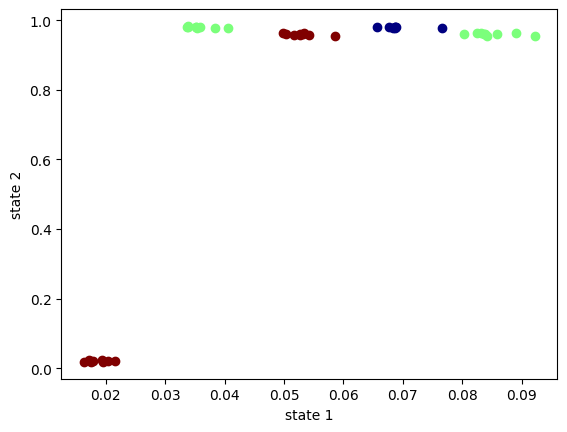

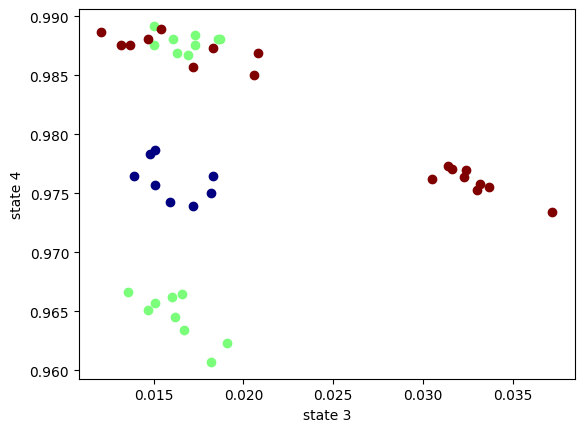

In [84]:
for ii in range(xstates.shape[-1] // 2):

    fig = plt.figure()
    ax = fig.add_subplot()

    cmap = plt.get_cmap('jet', len(np.unique(timeseries)))
    for i, x, y in zip(target, xstates[:, 2 * ii], xstates[:, 2 * ii + 1]):
        ax.scatter(x, y,  color=cmap(i))
    ax.set_xlabel(f'state {2 * ii + 1}')
    ax.set_ylabel(f'state {2*(ii+1)}')


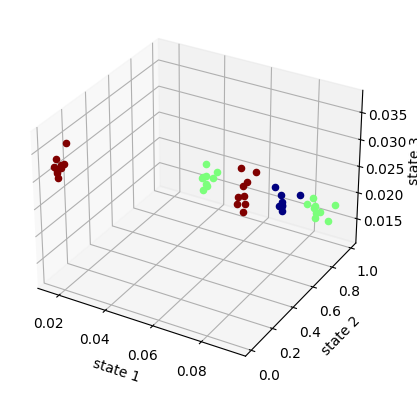

In [85]:
if xstates.shape[-1] >= 3:

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    cmap = plt.get_cmap('jet', len(np.unique(timeseries)))
    for i, x, y, z in zip(target, xstates[:, 0], xstates[:, 1], xstates[:, 2]):
        ax.scatter(x, y, z, color=cmap(i))
    ax.set_xlabel('state 1')
    ax.set_ylabel('state 2')
    ax.set_zlabel('state 3')

## Training

In [86]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler as Preprocessor
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV
from sklearn.neighbors import KNeighborsClassifier

In [87]:
models = np.array([
    SVC(kernel=ker) for ker in ['linear', 'poly', 'rbf', 'sigmoid']
] + [
    RidgeClassifier(alpha=alph) for alph in np.linspace(0, 1e-3, 20)
] + [
    KNeighborsClassifier(n_neighbors=n) for n in range(1, 10)
], dtype=object)

results = np.zeros(len(models))

N = 100
for _ in range(N):
    X_train, X_test, y_train, y_test = train_test_split(xstates, target, test_size=0.33)
    for i, model in enumerate(models):
        model.fit(X_train, y_train)
        score = model.score(X_test, y_test)
        results[i] += score

results /= N
sorting = np.flip(np.argsort(results))
for model, res in zip(models[sorting], results[sorting]):
    print(f'Score of {model}: {res}')


Score of KNeighborsClassifier(n_neighbors=3): 1.0
Score of KNeighborsClassifier(n_neighbors=2): 1.0
Score of KNeighborsClassifier(n_neighbors=1): 1.0
Score of KNeighborsClassifier(): 0.9993333333333334
Score of KNeighborsClassifier(n_neighbors=4): 0.9993333333333334
Score of KNeighborsClassifier(n_neighbors=6): 0.99
Score of KNeighborsClassifier(n_neighbors=7): 0.9766666666666667
Score of KNeighborsClassifier(n_neighbors=8): 0.9513333333333334
Score of KNeighborsClassifier(n_neighbors=9): 0.9153333333333334
Score of RidgeClassifier(alpha=0.0007368421052631579): 0.7433333333333327
Score of RidgeClassifier(alpha=0.0006842105263157895): 0.7426666666666661
Score of RidgeClassifier(alpha=0.0002105263157894737): 0.7426666666666661
Score of RidgeClassifier(alpha=0.0002631578947368421): 0.7426666666666661
Score of RidgeClassifier(alpha=0.00031578947368421053): 0.7426666666666661
Score of RidgeClassifier(alpha=0.0005263157894736842): 0.7426666666666661
Score of RidgeClassifier(alpha=0.000631578

## Predicting

In [88]:
predict_from = timeseries[-20:]
num_preds = 0


pred_states, preds = qres.predict(
    num_pred=num_preds,
    model=model,
    shots=SHOTS,
    from_series=predict_from
)


Predicting: 0it [00:00, ?it/s]


ValueError: cannot reshape array of size 0 into shape (0,newaxis)

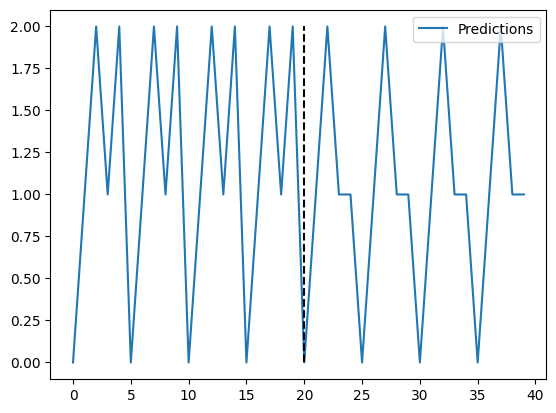

In [ ]:
true_values = timeseries

pred_plot = np.append(predict_from[-num_preds:], preds)
true_plot = np.append(predict_from[-num_preds:], true_values)

minlen = min(len(pred_plot), len(true_plot))

plt.plot(pred_plot[:minlen], label="Predictions")
plt.vlines(num_preds, ymin=np.min(target), ymax=np.max(target), colors='k', linestyles='dashed')
plt.plot(true_plot[:minlen], label="True timeseries")
plt.legend()